### Image classification using Pytorch
- Dataset: MNIST, Fashion MNIST
- Architecture : Neural Network, Convolution Neural Network
- Framework : Pytorch

### Digit MNIST
### 1. Load Libraries

In [34]:
# torch loading...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision loading...!!!
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchsummary import summary

# other libraries
import time
import numpy as np
import matplotlib.pyplot as plt

* `torchvision` is one of the most important modules of pytorch. you can download many dataset using `torchvision`.
* `torchvision.transform` will help us in the transformation of the pixel value of the images. Mainly `Normalization` and `Standarization`.


### 2. Define the transforms
Steps :
1. Convert dataset to tensor.
2. Normalize the dataset. Normalize indicates the value 0.5 means and standard deviation for each channels for grayscale MNIST dataset.

In [2]:
# tranforms used for the training, validation, and testing sets
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

### 3.Download Dataset
* you can download the dataset with `torchvisions.datasets`
* MNIST dataset has one argument transform arguments `transform=transform`, which is directly transform data into tensor and normalize.
* Dataset Contains `60000 Training samples` and `15000 batches` dataloader.
* `torch.utils.data.DataLoader` Data Loader to convert data into batches.

In [3]:
# get the data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

9913344it [00:00, 12039338.86it/s]                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



29696it [00:00, 30283017.65it/s]         

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



1649664it [00:00, 13109794.68it/s]                           

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


5120it [00:00, ?it/s]                   

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw




C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 4.Visualize the data

Image Shape: torch.Size([64, 1, 28, 28])
Target Shape: torch.Size([64])


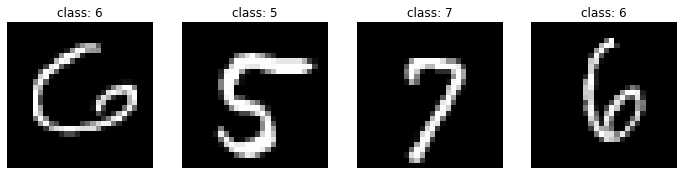

In [19]:
for batch_1 in trainloader:
    batch = batch_1
    break
print("Image Shape:", batch[0].shape) # as batch[0] contains the image pixels -> tensors
print("Target Shape:",batch[1].shape) # batch[1] contains the labels -> tensors
plt.figure(figsize=(12, 8))
for i in range (batch[0].shape[0]):
    # index to print first 4 images per batch
    if i == 4:
        break
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
    plt.title(f"class: {int(batch[1][i])}")
    # plt.savefig('digit_mnist.png')
plt.show()

### 5. Define the Neural Network

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 6.Check the GPU Availablity.

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model) 
print(str(summary(model, (1, 28, 28))))

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Conv2d: 1-2                            [-1, 50, 8, 8]            25,050
├─Linear: 1-3                            [-1, 500]                 400,500
├─Linear: 1-4                            [-1, 10]                  5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
Total mult-adds (M): 2.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Conv2d: 1-2         

### 7.Optimizer and Loss Function

In [41]:
# loss function for the network to optimize
criterion = nn.CrossEntropyLoss()

# optimizer for the network
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 8.Training the Neural Network on Data

In [57]:
def train(net):
    start = time.time()
    epoch_list = []
    loss_list = []
    # 1. Define the training loop
    for epoch in range(10): 
        running_loss = 0.0
        # 2. Load the training data
        for i, data in enumerate(trainloader, 0):
            # 3. Split the data into inputs and labels
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            
            # 4. set the parameters gradients to zero
            optimizer.zero_grad()
            
            # 5. predict the output
            outputs = net(inputs)
            
            # 6. Calculate the loss
            loss = criterion(outputs, labels)
            
            # 7. backpropagate the loss
            loss.backward()
            
            # 8. updatet the weigths
            optimizer.step()
            
            # 9. print the mini-batch loss
            running_loss += loss.item()
        epoch_list.append(epoch)
        loss_list.append(running_loss)
        print(f"[Epoch: {epoch+1}, Step: {i+1}] Loss: {running_loss:.3f}")
                
    end = time.time()
    print("Done Training...!!!")
    print(f"Training time: {(end-start)/60:.2f} Minutes")
    return epoch_list, loss_list      

In [59]:
epochs, losses = train(model)      

[Epoch: 1, Step: 938] Loss: 0.038
[Epoch: 2, Step: 938] Loss: 0.037
[Epoch: 3, Step: 938] Loss: 0.036
[Epoch: 4, Step: 938] Loss: 0.034
[Epoch: 5, Step: 938] Loss: 0.034
[Epoch: 6, Step: 938] Loss: 0.032
[Epoch: 7, Step: 938] Loss: 0.032
[Epoch: 8, Step: 938] Loss: 0.031
[Epoch: 9, Step: 938] Loss: 0.030
[Epoch: 10, Step: 938] Loss: 0.030
Done Training...!!!
Training time: 1.99 Minutes


### 9.Testing Network on the Test Set

In [60]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 99.26%
